# Local Differential Privacy and Reinforcement Learning

## DQN algorithm on CartPole

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl/blob/master/dqn_working.ipynb).

In this notebook we solve the Cartpole game using the DQN algorithm coupled with a MLP.

In the first part we train the network without DP, and in a second part we will manually add noise to the gradients.

## Import

In [ ]:
%matplotlib inline
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 108 kB/s 


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# **Classic DQN Training**

## Initialize environments

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_env = gym.make('CartPole-v1', new_step_api=True)
test_env = gym.make('CartPole-v1', new_step_api=True)
if gym.__version__[:4] == '0.26':
    train_env = gym.make('CartPole-v1')
    test_env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    train_env = gym.make('CartPole-v1', new_step_api=True)
    test_env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

### Seed

In [ ]:
SEED = 42
train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED);

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

## DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes 
rewards from the uncertain far future less important for our agent 
than the ones in the near future that it can be fairly confident 
about. It also encourages agents to collect reward closer in time 
than equivalent rewards temporally future away.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [ ]:
n_input = train_env.observation_space.shape[0]
n_hid = 128
n_output = train_env.action_space.n

In [ ]:
print(n_input,n_hid,n_output)

4 128 2


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_input=n_input, n_hid=n_hid, n_output=n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, n_hid)
        self.layer2 = nn.Linear(n_hid, n_hid)
        self.layer3 = nn.Linear(n_hid, n_output)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Action selection

In [ ]:
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# Greedy policy
def select_action(env, state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Training

In [ ]:
def compute_Q_values(memory, policy_net, target_net, batch_size, gamma):

    # If memory too small
    if len(memory) < batch_size:
        return None, None
    
    # Sample batch data
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) # Transpose the batch 

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    Q_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    max_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        max_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # Compute the expected Q values
    expected_Q_values = reward_batch + gamma * max_values

    return Q_values, expected_Q_values

In [ ]:
def update_policy(memory, policy_net, target_net, batch_size,
                  gamma, criterion, optimizer):

    # Recover Q_values
    Q_values, expected_Q_values = compute_Q_values(memory, policy_net,
                                                   target_net, batch_size, gamma)
    
    # If memory too small, no optimization
    if (Q_values is None) and (expected_Q_values is None):
      return np.inf

    # Compute Huber loss
    loss = criterion(Q_values, expected_Q_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# TAU is the update rate of the target network
TAU = 0.005

def train(memory, env, policy_net, target_net,
          batch_size, gamma, criterion, optimizer):

    policy_net.train()
    target_net.eval()
    episode_reward = 0
    n_samples = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        n_samples += 1
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize policy
        loss = update_policy(memory, policy_net, target_net, batch_size,
                             gamma, criterion, optimizer)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (policy_net_state_dict[key]*TAU 
                                          + target_net_state_dict[key]*(1-TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    return loss, episode_reward, n_samples

In [ ]:
def evaluate(env, policy_net):
    global steps_done
    policy_net.eval()
    episode_reward = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        steps_done -= 1 # do not update steps_done
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            break

    return episode_reward

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# LR is the learning rate of the AdamW optimizer
batch_size = 128
gamma = 0.99
lr = 1e-4
LOG = 10
N_TRIALS = 50
REWARD_THRESHOLD = 475
if torch.cuda.is_available():
    MAX_EPISODES = 600
else:
    MAX_EPISODES = 50

# Models
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

# Optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

# Criterion
criterion = nn.SmoothL1Loss()

# Memory Buffer
memory = ReplayMemory(10000)

steps_done = 0
nb_samples = [0]
losses = []
train_rewards = []
test_rewards = []

for episode in range(MAX_EPISODES):
    # Train model
    loss, train_reward, n_samples = train(memory, train_env, policy_net,
                                          target_net, batch_size,
                                          gamma, criterion, optimizer)
    # Evaluate model
    test_reward = evaluate(test_env, policy_net)

    # Update rewards 
    losses.append(loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    nb_samples.append(n_samples + nb_samples[-1])    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % LOG == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

nb_samples = nb_samples[1:]

| Episode:   0 | Mean Train Rewards:  45.0 | Mean Test Rewards:  21.0 |
| Episode:  10 | Mean Train Rewards:  23.5 | Mean Test Rewards:  17.3 |
| Episode:  20 | Mean Train Rewards:  19.0 | Mean Test Rewards:  17.7 |
| Episode:  30 | Mean Train Rewards:  17.1 | Mean Test Rewards:  16.1 |
| Episode:  40 | Mean Train Rewards:  16.0 | Mean Test Rewards:  14.9 |
| Episode:  50 | Mean Train Rewards:  14.6 | Mean Test Rewards:  14.6 |
| Episode:  60 | Mean Train Rewards:  12.6 | Mean Test Rewards:  13.8 |
| Episode:  70 | Mean Train Rewards:  12.2 | Mean Test Rewards:  12.7 |
| Episode:  80 | Mean Train Rewards:  12.2 | Mean Test Rewards:  12.8 |
| Episode:  90 | Mean Train Rewards:  12.3 | Mean Test Rewards:  13.3 |
| Episode: 100 | Mean Train Rewards:  12.9 | Mean Test Rewards:  13.3 |
| Episode: 110 | Mean Train Rewards:  13.7 | Mean Test Rewards:  14.1 |
| Episode: 120 | Mean Train Rewards:  14.8 | Mean Test Rewards:  14.9 |
| Episode: 130 | Mean Train Rewards:  38.1 | Mean Test Rewards: 

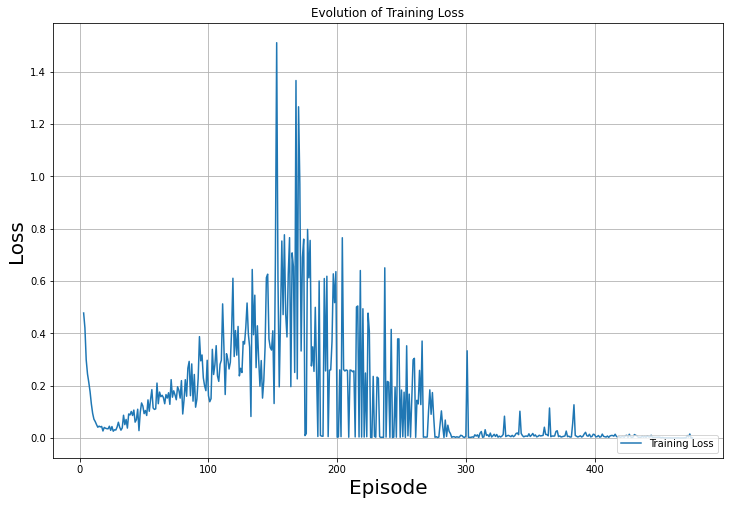

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(losses, label='Training Loss')
plt.title('Evolution of Training Loss')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(loc='lower right')
plt.grid()

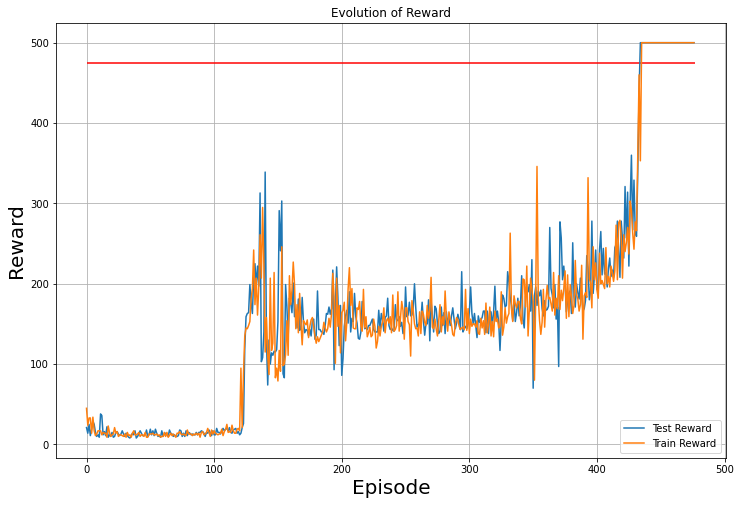

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.title('Evolution of Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [ ]:
## Model norms
for p in policy_net.parameters():
    print(torch.norm(p.grad))

tensor(0.6972, device='cuda:0')
tensor(0.4685, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(0.0291, device='cuda:0')
tensor(0.4149, device='cuda:0')
tensor(0.0064, device='cuda:0')


# **Introduce Differential Privacy on the gradient weights**

## Import

In [ ]:
%matplotlib inline
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 93 kB/s 


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Initialize environments

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_env = gym.make('CartPole-v1', new_step_api=True)
test_env = gym.make('CartPole-v1', new_step_api=True)
if gym.__version__[:4] == '0.26':
    train_env = gym.make('CartPole-v1')
    test_env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    train_env = gym.make('CartPole-v1', new_step_api=True)
    test_env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

### Seed

In [ ]:
SEED = 42
train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED);

## Replay Memory




In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN algorithm




In [ ]:
n_input = train_env.observation_space.shape[0]
n_hid = 128
n_output = train_env.action_space.n

In [ ]:
print(n_input,n_hid,n_output)

4 128 2


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_input=n_input, n_hid=n_hid, n_output=n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, n_hid)
        self.layer2 = nn.Linear(n_hid, n_hid)
        self.layer3 = nn.Linear(n_hid, n_output)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Action selection

In [ ]:
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# Greedy policy
def select_action(env, state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Training

## Adapt code to DP framework

In [ ]:
def compute_Q_batches(memory, batch_size):

    # If memory too small
    if len(memory) < batch_size:
        return None, None, None
    
    # Sample batch data
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) # Transpose the batch 

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    max_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        max_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # Compute the expected Q values
    expected_Q_values = reward_batch + gamma * max_values

    return state_batch, action_batch, expected_Q_values

## Compute gradient per sample

In [ ]:
from functorch import make_functional_with_buffers, vmap, grad

def compute_loss_stateless_model(params, buffers, state_sample, action_sample,
                                 expected_Q_values_sample, max_grad_norm,
                                 fmodel, criterion):
    batch = state_sample.unsqueeze(0)
    targets = expected_Q_values_sample.unsqueeze(0)

    predictions = fmodel(params, buffers, batch).gather(1, action_sample.unsqueeze(0))
    loss = criterion(predictions, targets.unsqueeze(1))
    return loss

ft_compute_grad = grad(compute_loss_stateless_model)

ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0, 0, None, None, None))
ft_compute_sample_loss = vmap(compute_loss_stateless_model, in_dims=(None, None, 0, 0, 0, None, None, None))


In [ ]:
def DP_update_policy(memory, policy_net, target_net, max_grad_norm, sigma,
                     batch_size, gamma, criterion, optimizer):

    # Recover batches
    state_batch, action_batch, expected_Q_values = compute_Q_batches(memory, batch_size)

    # If memory too small, no optimization
    if (state_batch is None) and (action_batch is None) and (expected_Q_values is None):
        return np.inf

    # Classic update
    if sigma == 0:

        # Recover Q_values
        Q_values = policy_net(state_batch).gather(1, action_batch)

        # Compute Huber loss
        loss = criterion(Q_values, expected_Q_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()

    # DP update
    else:
        # Recover gradient for all samples of the batch
        fmodel, params, buffers = make_functional_with_buffers(policy_net)
        sample_grads = ft_compute_sample_grad(params, buffers, state_batch,
                                              action_batch, expected_Q_values,
                                              max_grad_norm, fmodel, criterion)
        losses = ft_compute_sample_loss(params, buffers, state_batch,
                                        action_batch, expected_Q_values,
                                        max_grad_norm, fmodel, criterion)
        loss = torch.mean(losses)

        # Differential Privacy: clip gradients and add gaussian noise on weights
        for i, param in enumerate(policy_net.parameters()):
  
          # Clip inplace gradients seperately for each sample of the batch
          sample_grad = sample_grads[i]
          torch.nn.utils.clip_grad_norm_(sample_grad, max_norm=max_grad_norm)  # in-place

          # Aggregate gradients to have a unique grad for the batch
          param.grad = torch.mean(sample_grad, dim=0) 

          # Add noise
          noise = torch.normal(mean=0, std=sigma*max_grad_norm, size=param.size()).to(device)
          param.grad += noise/batch_size # Gaussian noise

    # Optimize model
    optimizer.step()

    return loss.item()

In [ ]:
# TAU is the update rate of the target network
TAU = 0.005

def DP_train(memory, env, policy_net, target_net, max_grad_norm,
             sigma, batch_size, gamma, criterion, optimizer):

    policy_net.train()
    target_net.eval()
    episode_reward = 0
    n_samples = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        n_samples += 1
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize policy with Differential Privacy
        loss = DP_update_policy(memory, policy_net, target_net, max_grad_norm,
                                sigma, batch_size, gamma, criterion, optimizer)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (policy_net_state_dict[key]*TAU 
                                          + target_net_state_dict[key]*(1-TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    return loss, episode_reward

In [ ]:
def evaluate(env, policy_net):
    global steps_done
    policy_net.eval()
    episode_reward = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        steps_done -= 1 # do not update steps_done
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            break

    return episode_reward

In [ ]:
batch_size = 128
gamma = 0.99
lr = 1e-4
LOG = 25
N_TRIALS = 25
REWARD_THRESHOLD = 475
if torch.cuda.is_available():
    MAX_EPISODES = 2000
else:
    MAX_EPISODES = 2000

# DP
noise_levels = [0, 0.1, 0.2, 0.4, 0.6] 

max_grad_norm = 0.1

train_rewards = np.zeros((len(noise_levels), MAX_EPISODES))
test_rewards = np.zeros((len(noise_levels), MAX_EPISODES))

for i, sigma in enumerate(noise_levels):
    train_env.reset(seed=SEED);
    test_env.reset(seed=SEED+1);
    
    print("-------------- Noise: sigma = {} ---------------\n".format(sigma))

    # Models
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    # Optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

    # Criterion
    criterion = nn.SmoothL1Loss()

    # Memory Buffer
    memory = ReplayMemory(10000)
    steps_done = 0  
    convergence = False
    
    for episode in range(MAX_EPISODES):
        if not convergence:
           # Train model
            loss, train_reward = DP_train(memory, train_env, policy_net,
                                          target_net, max_grad_norm, sigma,
                                          batch_size, gamma, criterion, optimizer)
            # Evaluate model
            test_reward = evaluate(test_env, policy_net)

            # Update rewards
            train_rewards[i][episode] = train_reward
            test_rewards[i][episode] = test_reward
            
            mean_train_rewards = np.mean(train_rewards[i][episode-N_TRIALS:episode+1])
            mean_test_rewards = np.mean(test_rewards[i][episode-N_TRIALS:episode+1])
            
            convergence = (mean_test_rewards) >= 475
            if convergence:
                print("Achieved convergence")
        else:
            train_rewards[i][episode] = train_rewards[i][episode-1]
            test_rewards[i][episode] = test_rewards[i][episode-1]
        
        if episode % LOG == 0:
            print(f'| Episode: {episode:3} | Train Reward: {train_reward:5.1f} | Test Reward: {test_reward:5.1f} |')

-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  26.0 | Test Reward:  18.0 |
| Episode:  25 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  15.0 | Test Reward:  15.0 |
| Episode:  75 | Train Reward:  13.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  11.0 | Test Reward:  10.0 |
| Episode: 125 | Train Reward:  17.0 | Test Reward:  16.0 |
| Episode: 150 | Train Reward:  40.0 | Test Reward:  44.0 |
| Episode: 175 | Train Reward: 179.0 | Test Reward: 172.0 |
| Episode: 200 | Train Reward: 154.0 | Test Reward: 183.0 |
| Episode: 225 | Train Reward: 177.0 | Test Reward: 169.0 |
| Episode: 250 | Train Reward: 174.0 | Test Reward: 144.0 |
| Episode: 275 | Train Reward: 143.0 | Test Reward: 136.0 |
| Episode: 300 | Train Reward: 146.0 | Test Reward: 120.0 |
| Episode: 325 | Train Reward: 124.0 | Test Reward: 133.0 |
| Episode: 350 | Train Reward: 236.0 | Test Reward: 144.0 |
| Episode: 375 | Train Reward: 125.0 | Test Reward:

In [ ]:
fig = plt.figure(figsize=(12,8))

for i, sigma in enumerate(noise_levels):
    plt.plot(test_rewards[i], label='sigma = {}'.format(sigma))

plt.xlabel('Number of episodes trained')
plt.ylabel('Reward')

plt.legend()
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.savefig('DP_DQN.png')